<a href="https://colab.research.google.com/github/LouisLortie/colab/blob/main/ecse_551_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import list

# from google.colab import drive                    # Need to activate this if using Google Colab (with drive)
import csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function that counts the number of features
def feature_count(data):
  return data.shape[1] - 1         # The last column is the class label

# Function that separates the input and output data
def get_xy_data(data):
    x = data[:,:-1]
    y = data[:,-1].reshape(-1,1)
    return x, y

In [23]:
# Function that classifies the training data into the two binary classes
def data_separation(data):

  count_class1 = 0
  count_class0 = 0
  
  for i in range(data.shape[0]) :      # all rows of data

    if data[i, -1] == 0 :
      if count_class0== 0 :
        data_class0 = data[[i], :]
      else :
        data_class0 = np.concatenate((data_class0, data[[i], :]), axis=0)
      count_class0+= 1

    elif data[i, -1] == 1 :
      if count_class1 == 0 :
        data_class1 = data[[i], :]
      else :
        data_class1 = np.concatenate((data_class1, data[[i], :]), axis=0)
      count_class1 += 1

  return data_class1, data_class0

In [24]:
#@title Load CSV

# drive.mount('/content/drive')                    # Activate on drive
# Reading air quality data
# aq_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/air_quality.csv")                 # Active on drive
aq_csv = pd.read_csv("air_quality.csv") 

# Reading liver patient data
# lp_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/liver_patient.csv")               # Active on drive
lp_csv = pd.read_csv("liver_patient.csv") 

# Array
aq_data = np.array(aq_csv)
lp_data = np.array(lp_csv)

# Divide into inputs and outputs
aq_x, aq_y = get_xy_data(aq_data)
lp_x, lp_y = get_xy_data(lp_data)

In [5]:
#@title Setting rcParams
plt.style.use('classic')
plt.rcParams.update({
                        #  "text.usetex": True,
                        #  "font.family": "serif",
                        #  "font.sans-serif": ["Times"],
                         "lines.linewidth" : 3,
                         "font.size" : 12,
                         "figure.constrained_layout.use" : True,
                         "hist.bins" : 100 
                         })

In [6]:
# Machine learning method: Classicifiation Discriminative learning
class DiscriminativeLearning():

    def __init__(self, x, y, step_size, epsilon):
        self.x = np.insert(x, 0, 1, axis=1)
        self.y = y
        self.step_size = step_size
        self.epsilon = epsilon
        self.w0 = np.zeros((self.x.shape[1], 1))
    
    def logistic_function(self, w, xi):
        a = w.T @ xi
        s = 1 / (1 + np.exp(-a))
        return s

    def fit(self):
        delta = 0
        w_old = self.w0
        w_new = w_old
        while True:
            w_old = w_new
            for i in range(self.x.shape[0]):
                xi = self.x[i].reshape(-1,1)
                yi = self.y[i]
                delta = delta - xi @ (yi - self.logistic_function(w_old, xi))
            w_new = w_old - self.step_size * delta
            error = np.linalg.norm(w_new - w_old, ord =2)
            if error < self.epsilon:
                break
        return w_new

    def predict(self, w, x):
        x = np.insert(x, 0, 1, axis=1)
        p = w.T @ x
        if p > 0.5:
            y = 1
        elif p == 0.5:
            # randomly choose 0 or 1
            y = np.random.randint(0,2)
        else:
            y = 0
        return y

In [13]:
#@title class_separation function: Separate the data into two classes
def class_separation(data):

  count_class0 = 0
  count_class1 = 0

  for i in range(data.shape[0]):

  if data[i, -1] == 0 :
    if count_class0 == 0 :
      data_class0 = data[[i], :]
    else :
      data_class0 = np.concatenate((data_class0, data[[i], :]), axis=0)
    count_class0 += 1

  elif data[i, -1] == 1 :
    if count_class1 == 0 :
      data_class1 = data[[i], :]
    else :
      data_class1 = np.concatenate((data_class1, data[[i], :]), axis=0)
    count_class1 += 1

      return data_class1, data_class0

In [90]:
#@title GenerativeLearning class: Generative model for binary classification

class GenerativeLearning:

  def __init__(self, data):
    self.data = data
    self.data_class1, self.data_class0 = data_separation(data)
    self.feat_count = feature_count(self.data)
    self.class1_count = self.data_class1.shape[0]
    self.class0_count = self.data_class0.shape[0]
    self.class1_prior = self.class1_count / self.data.shape[0]
    self.class0_prior = self.class0_count / self.data.shape[0]
    self.class1_mean = np.mean(self.data_class1[:,:-1], axis=0)
    self.class0_mean = np.mean(self.data_class0[:,:-1], axis=0)

    # Notice the difference in the covariance matrix calculation
    self.cov = ((self.data_class1[:,:-1] - self.class1_mean).T @ (self.data_class1[:,:-1] - self.class1_mean) + (self.data_class0[:,:-1] - self.class0_mean).T @ (self.data_class0[:,:-1] - self.class0_mean)) / (self.class1_count + self.class0_count - 2)
    self.cov_class1 = (self.data_class1[:,:-1] - self.class1_mean).T @ (self.data_class1[:,:-1] - self.class1_mean) / (self.class1_count - 1)
    self.cov_class0 = (self.data_class0[:,:-1] - self.class0_mean).T @ (self.data_class0[:,:-1] - self.class0_mean) / (self.class0_count - 1)
    

  def fit_lda_linear(self):

    self.w0 = np.log(self.class1_prior) - np.log(self.class0_prior) - 0.5 * self.class1_mean .T @ np.linalg.inv(self.cov) @ self.class1_mean + 0.5 * self.class0_mean .T @ np.linalg.inv(self.cov) @ self.class0_mean
    self.w1 = np.linalg.inv(self.cov) @ (self.class1_mean - self.class0_mean)
    self.w = np.concatenate((self.w0.reshape(1,), self.w1))

    return self.w


  def fit_qda_linear(self):      # Should be fine, but has not been tested out
      
      self.w0 = np.log(self.class1_prior) - np.log(self.class0_prior) + 0.5 * self.class1_mean .T @ np.linalg.inv(self.cov_class1) @ self.class1_mean - 0.5 * self.class0_mean .T @ np.linalg.inv(self.cov_class0) @ self.class0_mean - 0.5 * np.log(np.linalg.det(self.cov_class1)) + 0.5 * np.log(np.linalg.det(self.cov_class0))
      self.w1 = np.linalg.inv(self.cov_class1) @ self.class1_mean - np.linalg.inv(self.cov_class0) @ self.class0_mean
      self.w2 = (-0.5 * np.linalg.inv(self.cov_class1) + 0.5 * np.linalg.inv(self.cov_class0)).diagonal()

      print("w0 is ", self.w0.shape)
      print("w1 is ", self.w1.shape)
      print("w2 is ", self.w2.shape)
      print(self.w2)
      self.w = np.concatenate((self.w0.reshape(1,), self.w1, self.w2))

      
  
      return self.w


  def predict(self, x):

    self.y = x @ self.w[1:] + self.w[0]
    # print(self.y)
    
    return self.y


In [15]:
#@title augment_ones function: Function that augments the data with a column of ones
def augment_ones(data):
    ones = np.ones((data.shape[0], 1))
    return np.concatenate((data, ones), axis=1)

In [62]:
#@title increase_complexity function: Function that increases the complexity of the data

def increase_complexity(data, feat_num):
    # data = augment_ones(data)                                    # could be used to augment the data with a column of ones

    last_col = data[:, [-1]]
    data = data[:, :-1]

    for i in range(feat_num.shape[0]):
        data = np.concatenate((data, data[:, [feat_num[i]]]**2), axis=1)   # augment the matrix by adding a column of the square of the feature

    data = np.concatenate((data, last_col), axis=1)       # add the last column back to the matrix

    return data

In [17]:
#@title fold_prep: Separates data into testing, validation and testing sets
def fold_prep(data, train_num, validation_num, test_num):
    # np.random.shuffle(data)
    data_train = data[:train_num, :]
    data_val = data[train_num:train_num+validation_num, :]
    data_test = data[train_num+validation_num:train_num+validation_num+test_num, :]
    return data_train, data_val, data_test

In [18]:
#@title plot hist: Function that plots the histogram of one feature
# The number of bins can be changed via rcParams above.

def plot_hist(feat_class1, feat_class0, feat_num):
  fig, ax = plt.subplots(2, 1, sharex=True)
  ax[0].hist(feat_class1, color="b", label=r"Class y = 1")
  ax[1].hist(feat_class0, color="r", label=r"Class y = 0")
  ax[0].set_title("Feature %i distribution comparison between classes" %(feat_num + 1))
  ax[0].legend(loc='upper right')
  ax[1].legend(loc='upper right')
  plt.tight_layout

  return 0

In [89]:
#@title prediction_line: Function that plots the regression line

# Only used to show linear LDA. Not used for QDA.

def prediction_line(x_class1, x_class0, w): 

    count_false1 = 0
    count_false0 = 0
    
    x = (np.concatenate((x_class1, x_class0), axis=0)).reshape(-1, 1)
    
    fig, ax = plt.subplots(1, 1)
    y_class1 = x_class1 @ w[1:] + w[0]
    y_class0 = x_class0 @ w[1:] + w[0]
    range1 = np.linspace(np.min(x), np.max(x), y_class1.shape[0])
    range2 = np.linspace(np.min(x), np.max(x), y_class0.shape[0])

    for i in range(y_class1.shape[0]):
        if y_class1[i] < 0:
            count_false1 += 1

    for i in range(y_class0.shape[0]):
        if y_class0[i] > 0:
            count_false0 += 1

    print("Number of false positives: %i" %(count_false1))
    print("Number of false negatives: %i" %(count_false0))
    print("Total of class1: %i" %(y_class1.shape[0]))
    print("Total of class0: %i" %(y_class0.shape[0]))

    ax.scatter(range1, y_class1, color="b", label=r"Class y = 1")
    ax.scatter(range2, y_class0, color="r", label=r"Class y = 0")
    ax.plot([np.min(x), np.max(x)], [0, 0], color="g")
    ax.set_title("Predictions")
    ax.legend(loc='upper right')
    plt.tight_layout
    
    return 0

Number of false positives: 218
Number of false negatives: 190
Total of class1: 854
Total of class0: 744


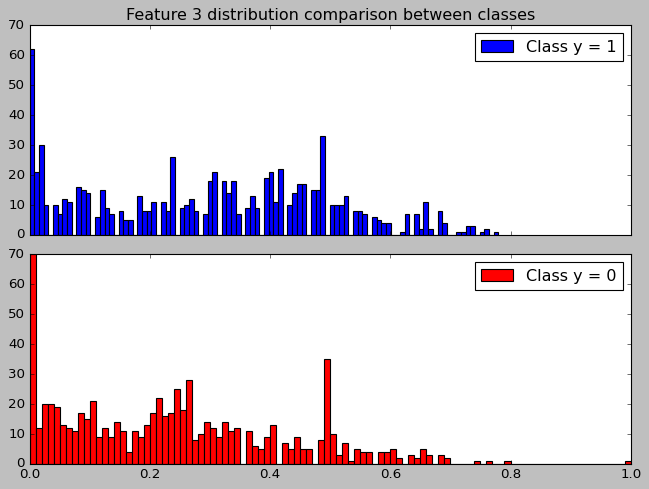

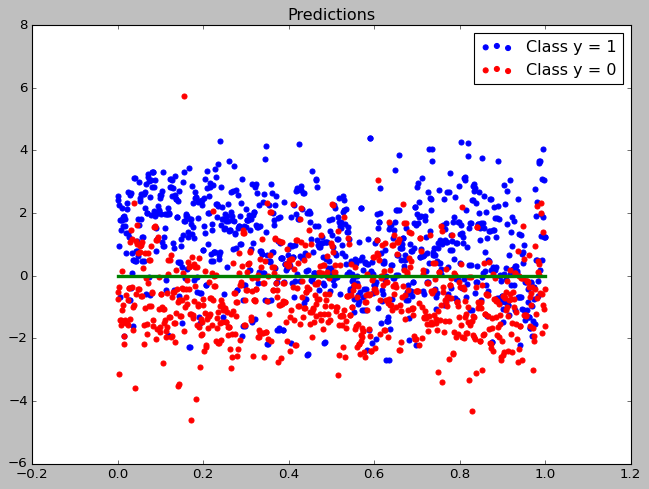

In [92]:
#@title Main function
def main():

  feat = 2   # Feature to analyse.

  aq_data_aug = increase_complexity(aq_data, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))

  # print (aq_data_aug.shape)
  # print(aq_data_aug)

  data_class1, data_class0 = data_separation(aq_data)
  
  plot_hist(data_class1[:, feat], data_class0[:, feat], feat)

  # Divide into inputs and outputs
  # aq_x, aq_y = get_xy_data(aq_data)
  # lp_x, lp_y = get_xy_data(lp_data)
  # # aq_dl = DiscriminativeLearning(aq_x, aq_y, 0.001, 0.01)
  # lp_dl = DiscriminativeLearning(lp_x, lp_y, 0.001, 0.01)
  # # w1 = aq_dl.fit()
  # w2 = lp_dl.fit()
  # print(w2)
  
  # plot_hist(data_class1[:,data_class0 feat], data_class0[:, feat], feat)
  
  model2 = GenerativeLearning(aq_data)

  # data_class1, data_class0 = data_separation(aq_data)
  
  w = model2.fit_lda_linear()
  model2.predict(aq_data[:, :-1])
  prediction_line(data_class1[:, :-1], data_class0[:, :-1], model2.w)
  
if __name__ == '__main__':
    main()